# Basic Concepts

This tutorial is an introduction to medicinal chemistry molecular filtering. It will show that applying those type of filters and rules systematically and blindly is often **not a good idea**. While powerful, such filtering technics must always be carefully assesed and prototyped before using systematically and at large scale.


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from rdkit.Chem import PandasTools
import datamol as dm
import pandas as pd

import medchem as mc


## Marketed drugs does not always pass medchem filters

The most obvious example for not blindly applying medicinal filters, alerts and rules systematically is when looking at the already approved and marketed drugs. The below example shows that for many common filters, a large proportion of approved drugs does not pass them.

That being said it's important to keep in mind that all the approved drugs has gone into a very long and lengthy development process in which their structures have been further optimized and finetuned. During that process it's very common to include or exclude particular features that early during a drug pipeline could have been seen as an unwanted feature but turned out to be a beneficial one during the late stages of a program.


In [2]:
# Load ChEMBL approved and marketed drugs
data = pd.read_parquet("./data/chembl_approved_drugs.parquet")

# Build mol objects
data["mol"] = data["smiles"].apply(dm.to_mol)

# Apply basic rules
data["rule_of_five"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_five)
data["rule_of_ghose"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_ghose)
data["rule_of_veber"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_veber)
data["rule_of_zinc"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_zinc)

# Apply some default medchem filters
data["alerts_BMS"] = mc.functional.alert_filter(
    mols=data["mol"].tolist(),
    alerts=["BMS"],
    n_jobs=-1,
    progress=True,
    return_idx=False,
)
data["alerts_PAINS"] = mc.functional.alert_filter(
    mols=data["mol"].tolist(),
    alerts=["PAINS"],
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["alerts_SureChEMBL"] = mc.functional.alert_filter(
    mols=data["mol"].tolist(),
    alerts=["SureChEMBL"],
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filters_NIBR"] = mc.functional.nibr_filter(
    mols=data["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_complexity"] = mc.functional.complexity_filter(
    mols=data["mol"].tolist(),
    complexity_metric="bertz",
    threshold_stats_file="zinc_15_available",
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_bredt"] = mc.functional.bredt_filter(
    mols=data["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_molecular_graph"] = mc.functional.molecular_graph_filter(
    mols=data["mol"].tolist(),
    max_severity=5,
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_lilly_demerit"] = mc.functional.lilly_demerit_filter(
    mols=data["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)


[17:20:36] WARNING: not removing hydrogen atom without neighbors
[17:20:36] WARNING: not removing hydrogen atom without neighbors
[17:20:36] WARNING: not removing hydrogen atom without neighbors
[17:20:36] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:37] WARNING: not removing hydrogen atom without neighbors
[17:20:38] WARNING: not removing hydrogen atom without neighbors
[17:20:38] WARNING: not removing hydrogen atom without neighbors
[17:20:38] WARNING: not removing hydrogen atom without neighbors
[17:20:38] WARNING: not r

Common alerts filtering:   0%|          | 0/2628 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/2628 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/2628 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/2628 [00:00<?, ?it/s]

Complexity Evaluation:   0%|          | 0/2628 [00:00<?, ?it/s]

To mol:   0%|          | 0/2628 [00:00<?, ?it/s]

Filtering with catalogs:   0%|          | 0/26 [00:00<?, ?it/s]

Match:   0%|          | 0/2628 [00:00<?, ?it/s]

[17:21:08] WARNING: not removing hydrogen atom without neighbors
[17:21:08] WARNING: not removing hydrogen atom without neighbors
[17:21:08] WARNING: not removing hydrogen atom without neighbors
[17:21:08] WARNING: not removing hydrogen atom without neighbors


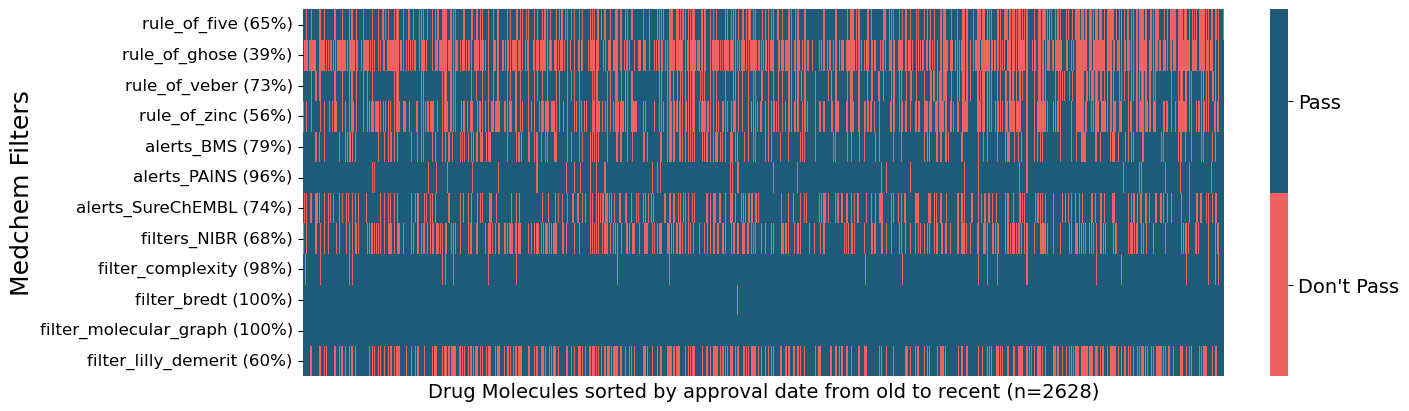

In [8]:
filter_columns = [
    "rule_of_five",
    "rule_of_ghose",
    "rule_of_veber",
    "rule_of_zinc",
    "alerts_BMS",
    "alerts_PAINS",
    "alerts_SureChEMBL",
    "filters_NIBR",
    "filter_complexity",
    "filter_bredt",
    "filter_molecular_graph",
    "filter_lilly_demerit",
]

# Some sorting for a nice plot
data["n_filters_pass"] = data[filter_columns].sum(axis=1)
data = data.sort_values("first_approval", ascending=True)

# Plot

f, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

cmap = matplotlib.colors.ListedColormap(["#EF6262", "#1D5B79"], None)

a = sns.heatmap(
    data[filter_columns].T,
    annot=False,
    ax=ax,
    xticklabels=False,  # type: ignore
    yticklabels=True,  # type: ignore
    cbar=True,
    cmap=cmap,
)

ax.collections[0].colorbar.set_ticks([0.25, 0.75])
ax.collections[0].colorbar.set_ticklabels(["Don't Pass", "Pass"], fontsize=14)

ax.set_xlabel(f"Drug Molecules sorted by approval date from old to recent (n={len(data)})", fontsize=14)
ax.set_ylabel("Medchem Filters", fontsize=18)

# Add percentage of passing mols in the y labels
new_ylabels = []
for t in ax.yaxis.get_ticklabels():
    perc = data[t.get_text()].sum() / len(data) * 100
    new_ylabels.append(f"{t.get_text()} ({perc:.0f}%)")
_ = ax.yaxis.set_ticklabels(new_ylabels, fontsize=12)


## Showcasing pro-drugs

Some drugs are designed as [prodrug](https://en.wikipedia.org/wiki/Prodrug) that will be only be made active once in the human body after being metabolized. Those compounds will tend to have unwanted molecular features that are often flagged by common alerts and rules.

Below we load a small dataset of 7 drug/prodrug pairs and apply some common medchem rules on them.

,Drug,Drug mol,Prodrug,Prodrug mol,rule_of_five,rule_of_ghose,rule_of_veber,rule_of_zinc
0,Gabapentin,,Gabapentin enacarbil,,Ro5Drug: TrueProdrug: True,GhoseDrug: FalseProdrug: True,VeberDrug: TrueProdrug: True,ZincDrug: TrueProdrug: True
1,Dabigatran,,Dabigatran etexilate,,Ro5Drug: TrueProdrug: False,GhoseDrug: FalseProdrug: False,VeberDrug: FalseProdrug: False,ZincDrug: FalseProdrug: False
2,Sofosbuvir,,Sofosbuvir,,Ro5Drug: TrueProdrug: False,GhoseDrug: FalseProdrug: False,VeberDrug: FalseProdrug: False,ZincDrug: FalseProdrug: False
3,Tedizolid,,Tedizolid phosphate,,Ro5Drug: TrueProdrug: False,GhoseDrug: TrueProdrug: True,VeberDrug: TrueProdrug: False,ZincDrug: TrueProdrug: False
4,Isavuconazole,,Isavuconazonium,,Ro5Drug: TrueProdrug: False,GhoseDrug: TrueProdrug: False,VeberDrug: TrueProdrug: False,ZincDrug: TrueProdrug: False
5,Aripiprazole,,Aripiprazole lauroxil,,Ro5Drug: TrueProdrug: False,GhoseDrug: TrueProdrug: False,VeberDrug: TrueProdrug: False,ZincDrug: TrueProdrug: False
6,ACT-333679,,Selexipag,,Ro5Drug: TrueProdrug: True,GhoseDrug: TrueProdrug: False,VeberDrug: FalseProdrug: False,ZincDrug: TrueProdrug: True

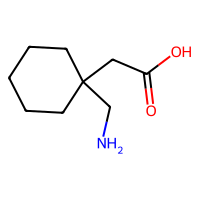
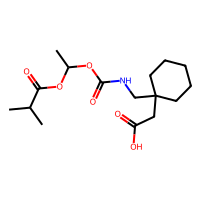
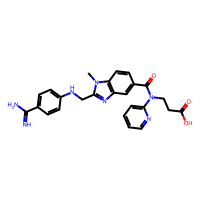
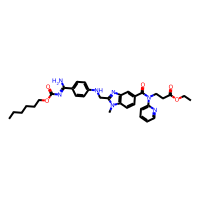
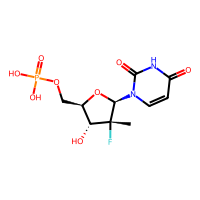
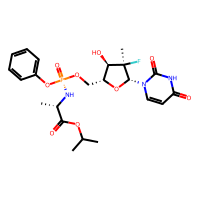
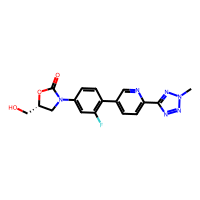
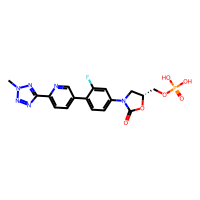
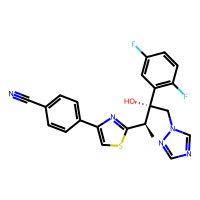
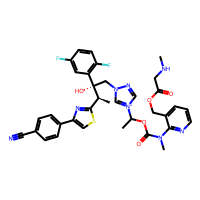
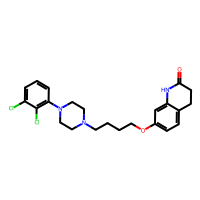
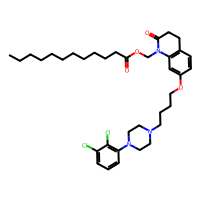
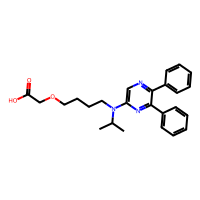
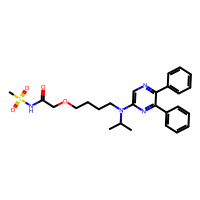

In [69]:
# Load the dataset
data = pd.read_csv("./data/Drug_Prodrug_pairs.csv")

# Compute mol objects
data["Drug mol"] = data["Drug SMILES"].apply(dm.to_mol)
data["Prodrug mol"] = data["Prodrug SMILES"].apply(dm.to_mol)

# Reorder the columns
data = data[["Drug", "Drug mol", "Prodrug", "Prodrug mol"]]


# Apply a few medchem rules to the drugs and prodrugs
def _apply_rules(row):
    rule_names = [
        ("Ro5", "rule_of_five"),
        ("Ghose", "rule_of_ghose"),
        ("Veber", "rule_of_veber"),
        ("Zinc", "rule_of_zinc"),
    ]

    for rule_label, rule_name in rule_names:
        rule_fn = getattr(mc.rules.basic_rules, rule_name)

        # Apply the rule to the drug and prodrug
        drug_ok = rule_fn(dm.copy_mol(row["Drug mol"]))
        prodrug_ok = rule_fn(dm.copy_mol(row["Prodrug mol"]))

        row[rule_name] = f"{rule_label}\nDrug: {drug_ok}\nProdrug: {prodrug_ok}"

    return row


data = data.apply(_apply_rules, axis=1)

# Enable drawing in the dataframe
PandasTools.ChangeMoleculeRendering(data)

# Small hack to display new lines as well as RDKit drawings
HTML(data.to_html().replace("\\n", "<br>"))


While this is not systematic, we observe that many drugs passes the rules while the associated prodrugs does not pass them.

---

-- The End :-)